In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmitgcm import open_mdsdataset

import pych
import pych.ecco as pe

from smooth_store import open_smoothdataset

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
run_dir='/scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/run.05dx.0.5xi/'
ds = open_mdsdataset(run_dir,
                              iters=None,
                              geometry='llc',
                              )

/home/tsmith/xmitgcm/xmitgcm/mds_store.py:922: UserWarning: Couldn't find available_diagnostics.log in /scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/run.05dx.0.5xi/ or /scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/run.05dx.0.5xi/. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "


In [98]:
def get_smooth_vars(smoothOpNb):
    
    extra_variables = {
        f'smooth3DKux{smoothOpNb}': {
            'dims': ['k', 'j', 'i_g'],
            'attrs': {
                'standard_name': 'kux',
                'long_name': 'k11'
            }
        },
        f'smooth3DKvy{smoothOpNb}': {
            'dims': ['k', 'j', 'i_g'],
            'attrs': {
                'standard_name': 'kvy',
                'long_name': 'k22'
            }
        },
        f'smooth3DKwz{smoothOpNb}': {
            'dims': ['k_l', 'j', 'i'],
            'attrs': {
                'standard_name': 'kwz',
                'long_name': 'k33'
            }
        },
        f'smooth3DDelta{smoothOpNb}': {
            'dims': ['k', 'j', 'i'],
            'attrs': {
                'standard_name': 'delta',
                'long_name': 'delta'
            }
        },
        f'smooth3Dnorm{smoothOpNb}': {
            'dims': ['k', 'j', 'i'],
            'attrs': {
                'standard_name': 'norm',
                'long_name': 'norm',
            }
        },
        f'smooth3Dmean{smoothOpNb}': {
            'dims': ['k', 'j', 'i'],
            'attrs': {
                'standard_name': 'sample_mean',
                'long_name': 'sample_mean',
            }
        },
        f'smooth3DRandNorm{smoothOpNb}': {
            'dims': ['k', 'j', 'i'],
            'attrs': {
                'standard_name': 'rand_norm',
                'long_name': 'rhs_factor',
            }
        },
    }
    return extra_variables

In [104]:
import os

def open_smoothdataset(run_dir,
                       xdalike,
                       read_filternorm=False,
                       n_samples=1000,
                       **kwargs):
    """
    TODO:
        - don't pass xdalike ... because would need one for every operator type
        - ideally... write smooth package to use diagnostics to write out the smoothed field
        - read_filternorm necessary for OIDriver still?
        - split up different operators, remove number from variable name (add as dimension)
        - add 2D variables... etc
    """
    
    # get all smooth*.data prefixes, then their operator numbers
    prefixes = [x for x in os.listdir(run_dir) if 'smooth' in x and '.data' in x]
    numbers = [x.split('.')[0][-3:] for x in prefixes] 
    
    # Right now operators will be a list of strings, since going to want string not int anyway...
    operators = []
    for x in numbers:
        if x not in operators:
            operators.append(x)
    
    extras = [get_smooth_vars(op) for op in operators]
    custom_grid_variables = {}
    for fld in extras:
        custom_grid_variables.update(fld)
        
    xds = xmitgcm.open_mdsdataset(run_dir, custom_grid_variables=custom_grid_variables, **kwargs)
    smoothvars = [vname for vname in xds.coords if 'smooth' in vname]
    xds = xds.reset_coords(smoothvars)
    
    # rechunk to have full 2D field
    # Now get the field
    # HACK: assumes LLC, assumes 3D operator 1, number of samples ... ideally don't need to input
    sample = np.arange(n_samples)
    xds['sample'] = xr.DataArray(sample,
                          coords={'sample':sample},
                          dims=('sample',))
    smoothfld = xmitgcm.utils.read_3d_llc_data(run_dir+'/smooth3Dfld001.data', nx=len(ds.i), nz=len(ds.k),
                                               nrecs=n_samples,
                                               dtype=ds.Depth.dtype,
                                               memmap=False)
    template = xdalike.broadcast_like(xds.sample)
    xds['smooth3Dfld001'] = xr.DataArray(smoothfld, coords=template.coords, dims=template.dims)
    for vname in xds.data_vars:
        xds[vname] = xds[vname].chunk({'face':None})
    
    return xds

In [3]:
ds =open_smoothdataset(run_dir,ds.maskC, geometry='llc', iters=None)

/home/tsmith/xmitgcm/xmitgcm/mds_store.py:922: UserWarning: Couldn't find available_diagnostics.log in /scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/run.05dx.0.5xi/ or /scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/run.05dx.0.5xi/. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "


In [7]:
ds.smooth3Dfld001.chunk({'k':None})

<xarray.DataArray 'smooth3Dfld001' (sample: 1000, k: 50, face: 13, j: 90, i: 90)>
dask.array<rechunk-merge, shape=(1000, 50, 13, 90, 90), dtype=>f4, chunksize=(1, 50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ...       ...
    rhoRef   (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    dxF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rLowC    (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfC   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

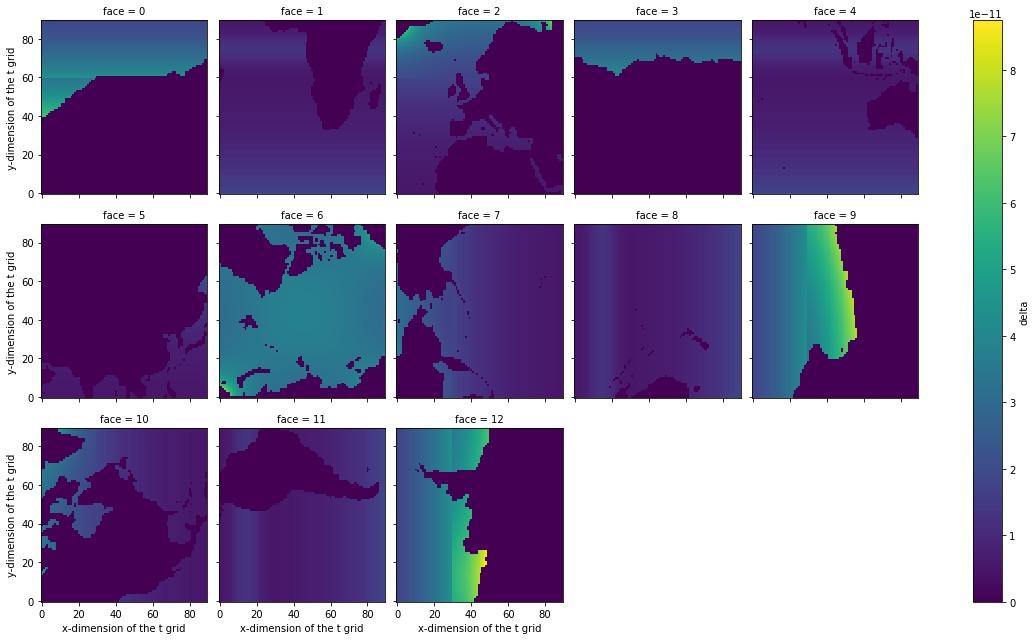

In [4]:
ds.smooth3DDelta001.where(ds.maskC,0.).isel(k=0).plot(col='face',col_wrap=5)

In [82]:
ds.reset_coords(['hFacC','rA'])

<xarray.Dataset>
Dimensions:              (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                          k_l: 50, k_p1: 51, face: 13)
Coordinates: (12/55)
  * i                    (i) int64 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
  * i_g                  (i_g) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j                    (j) int64 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
  * j_g                  (j_g) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * k                    (k) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * k_u                  (k_u) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
    ...                   ...
    rLowC                (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rLowW                (face, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rLowS                (face, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfC               (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfW               (face, j, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfS               (face, j_g, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
Data variables:
    rA                   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    hFacC                (k, face, j, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [71]:
ds.smooth3Dnorm001

<xarray.DataArray 'smooth3Dnorm001' (k: 50, face: 13, j: 90, i: 90)>
dask.array<getitem, shape=(50, 13, 90, 90), dtype=>f4, chunksize=(1, 1, 90, 90), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * i                    (i) int64 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
  * j                    (j) int64 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
  * k                    (k) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * face                 (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC                   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC                   (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ...                   ...
    smooth3Dnorm001      (k, face, j, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    smooth3Dmean001      (k, face, j, i) >f4 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    dxF                  (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyF                  (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rLowC                (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rSurfC               (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
Attributes:
    standard_name:  norm
    long_name:      norm

In [ ]:
llcmap = pe.atlantic_map(ds)

In [ ]:
llcmap(ds.smooth3Dnorm001.isel(k=0))